### Establish a baseline performance. How well did your RL Q-learning do on your problem?

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import gym

In [3]:
env = gym.make('MountainCar-v0')

In [4]:
env.action_space.n

3

In [5]:
env.action_space.n

3

In [6]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)

In [7]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

In [8]:
print(env.reset())

[-0.40643329  0.        ]


In [9]:
print(env.step(2))

(array([-4.06294044e-01,  1.39242089e-04]), -1.0, False, {})


In [10]:
env.max_episode_steps = 100

In [11]:
env.max_episode_steps

100

In [12]:
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    reward_list = []
    ave_reward_list = []
    car_position = []
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
#             if i >= (episodes - 20):
#                 env.render()
                
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            state2, reward, done, info = env.step(action) 
            
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
            else:
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
            
            
            tot_reward += reward
            state_adj = state2_adj
            
            if epsilon > min_eps:
                epsilon -= reduction
                
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

In [13]:
rewards = QLearning(env, 0.7, 0.8, 1.0, 0, 5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -98.93400265008664
Episode 300 Average Reward: -97.55023824321525
Episode 400 Average Reward: -99.05202341562739
Episode 500 Average Reward: -97.75712291224986
Episode 600 Average Reward: -90.06468879904334
Episode 700 Average Reward: -77.0121422945655
Episode 800 Average Reward: -74.16906572514938
Episode 900 Average Reward: -74.59835290941001
Episode 1000 Average Reward: -74.82151029748283
Episode 1100 Average Reward: -74.37666734376057
Episode 1200 Average Reward: -74.23931623931624
Episode 1300 Average Reward: -74.6838165879973
Episode 1400 Average Reward: -74.3279810298103
Episode 1500 Average Reward: -74.43585926928282
Episode 1600 Average Reward: -74.30532023043037
Episode 1700 Average Reward: -74.32682926829268
Episode 1800 Average Reward: -74.2853172451193
Episode 1900 Average Reward: -74.44463234796726
Episode 2000 Average Reward: -74.50868536667794
Episode 2100 Average Reward: -74.26837537293193
Episode 2200 Aver

In [14]:
rewards

[-0.4031952861239486,
 -0.4202317066525107,
 -0.6837441749621365,
 -0.5204014569439038,
 -0.6100752597932324,
 -0.5959079866228093,
 -0.679749936323738,
 -0.5342087034506511,
 -0.5608804736867847,
 -0.47444684511617596,
 -0.4884023362115045,
 -0.47578662877123157,
 -0.5169468949868103,
 -0.570349605195572,
 -0.5976010495930913,
 -0.7720804943699736,
 -0.7229550329475323,
 -0.9364999063998104,
 -0.11893336129213206,
 -0.18395547333650913,
 -0.3363118930205193,
 -0.24514206820400458,
 -0.5077217992147299,
 -0.5168466373098324,
 -0.3365370554383691,
 -0.8473137929365705,
 -0.45054200961223967,
 -0.7341798850593577,
 -0.36168589853539646,
 -0.7578677397225392,
 -0.3835577475308779,
 -0.45326290664108937,
 -0.19025475287019217,
 -0.9927553364030501,
 -0.11870431666543424,
 0.03061040763460554,
 0.03108307273079062,
 0.23428810850112178,
 -0.7385109510236877,
 0.11201344378429202,
 -0.7098527063786566,
 -0.17195583255239905,
 -0.202852896709757,
 -0.06490319981700696,
 -0.04542553077768364,


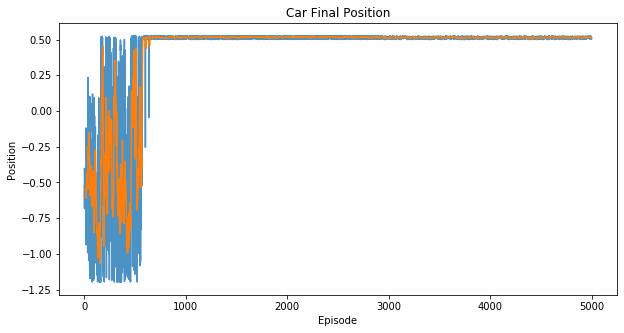

In [15]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

### What are the states, the actions and the size of the Q-table?

States 

Position = -1.2 to 0.6   
Velocity = -0.07 to 0.07

Actions - PushLeft, PushRight, NoPush

Size of Q-table :

(0.6+1.2+0.1)*10 = 19   
(0.07+0.07+0.01) = 15   
action space = 3

Q table size = (19*15*3)


### What are the rewards? Why did you choose them?

Rewards are -1 for each time step, until the goal position of 0.5 is reached.

### How did you choose alpha and gamma in the following equation?
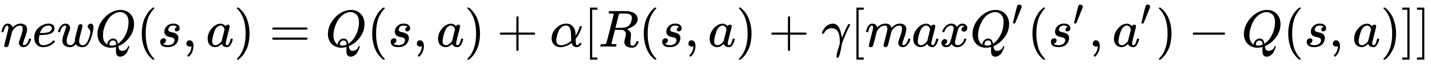

Try at least one additional value for alpha and gamma. How did it change the baseline performance?


The learning rate, set between 0 and 1. Setting it to 0 means that the Q-values are never updated, hence nothing is learned. Setting a high value such as 0.9 means that learning can occur quickly.

The discount factor, also set between 0 and 1. This models the fact that future rewards are worth less than immediate rewards. Mathematically, the discount factor needs to be set less than 0 for the algorithm to converge

In [16]:
rewards_new = QLearning(env, 0.9, 0.6, 1.0, 0, 5000)

Episode 100 Average Reward: -100.5
Episode 200 Average Reward: -99.83697021619714
Episode 300 Average Reward: -100.33375087684136
Episode 400 Average Reward: -98.54761904761905
Episode 500 Average Reward: -97.920245398773
Episode 600 Average Reward: -97.9548856656171
Episode 700 Average Reward: -99.30547097036134
Episode 800 Average Reward: -93.54556335346281
Episode 900 Average Reward: -96.02446370072916
Episode 1000 Average Reward: -97.99149265274555
Episode 1100 Average Reward: -98.42128750961785
Episode 1200 Average Reward: -98.63701394921057
Episode 1300 Average Reward: -98.09081081081081
Episode 1400 Average Reward: -85.91917685654637
Episode 1500 Average Reward: -88.115896541703
Episode 1600 Average Reward: -92.43270084332002
Episode 1700 Average Reward: -90.16467562160618
Episode 1800 Average Reward: -100.33967935871743
Episode 1900 Average Reward: -94.78424177010254
Episode 2000 Average Reward: -81.3935834280662
Episode 2100 Average Reward: -80.3347549331636
Episode 2200 Avera

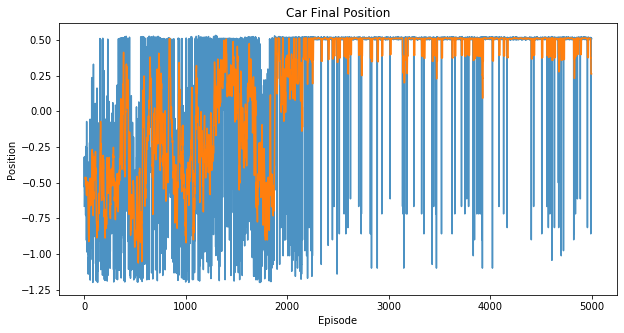

In [17]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_new)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

In [37]:
def QLearning_NR(env, learning, discount, epsilon, min_eps, episodes):
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    reward_list = []
    ave_reward_list = []
    car_position = []
    reduction = (epsilon - min_eps)/episodes
    
    for i in range(episodes):
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        
        while done != True:
#             if i >= (episodes - 5):
#                 env.render()
                
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            state2, reward, done, info = env.step(action) 
            
#             Adjust reward based on car position
            reward = state2[0] - 0.5
        
       
 
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            if done and state2[0] >= 0.5:
#                 Adjust reward for task completion
                reward+=3
                Q[state_adj[0], state_adj[1], action] = reward
            else:
                delta = learning*(reward + 
                                 discount*(np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action]))
                Q[state_adj[0], state_adj[1],action] += delta
            
            
            tot_reward += reward
            state_adj = state2_adj
            
            if epsilon > min_eps:
                epsilon -= reduction
                
            
            reward_list.append(tot_reward)
        
        car_position+=[state2[0]]
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
            
    env.close()
    
    return car_position
        
    

In [38]:
rewards_NR = QLearning_NR(env, 0.7, 0.8, 1.0, 0, 5000)

Episode 100 Average Reward: -101.70915678617516
Episode 200 Average Reward: -99.53827940931029
Episode 300 Average Reward: -100.91541004602483
Episode 400 Average Reward: -100.77100053216938
Episode 500 Average Reward: -97.95874486740206
Episode 600 Average Reward: -97.73167219765905
Episode 700 Average Reward: -90.31074214138985
Episode 800 Average Reward: -88.13256484774475
Episode 900 Average Reward: -88.59082557384373
Episode 1000 Average Reward: -95.65763680892893
Episode 1100 Average Reward: -99.5879044314963
Episode 1200 Average Reward: -102.16615008194098
Episode 1300 Average Reward: -97.33112220555269
Episode 1400 Average Reward: -92.13342554385873
Episode 1500 Average Reward: -80.49495653042838
Episode 1600 Average Reward: -80.26982914070821
Episode 1700 Average Reward: -77.49669226473348
Episode 1800 Average Reward: -77.10850634617293
Episode 1900 Average Reward: -77.04945755931539
Episode 2000 Average Reward: -76.80646907231664
Episode 2100 Average Reward: -77.0638305652313

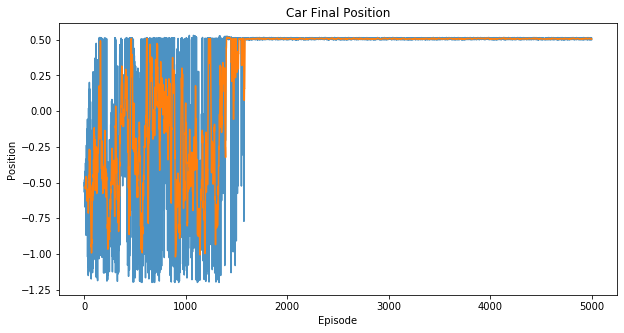

In [39]:
plt.figure(2, figsize=[10,5])
p = pd.Series(rewards_NR)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

### Try a policy other than maxQ(s', a'). How did it change the baseline performance?

### How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?

### What is the average number of steps taken per episode?

### Does Q-learning use value-based or policy-based iteration?

### What is meant by expected lifetime value in the Bellman equation?

In [51]:
state2, reward, done, info = env.step(2)

In [52]:
done

True

In [25]:
state2

array([-0.19892221,  0.01728908])

In [47]:
env.observation_space.high - env.observation_space.low

array([1.8000001, 0.14     ], dtype=float32)

In [38]:
num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])

In [40]:
num_states = np.round(num_states, 0).astype(int) + 1

In [42]:
num_states

array([19, 15])

In [45]:
env.action_space.n

3

In [43]:
Q = np.random.uniform(low = -1, high = 1, size = (num_states[0], num_states[1],env.action_space.n))

In [44]:
Q

array([[[ 5.43620385e-01, -7.44004824e-01, -5.44549959e-01],
        [ 5.42504282e-01,  1.30608500e-01, -2.06217451e-01],
        [-1.11875480e-01, -8.22016151e-02, -7.01591749e-01],
        [-9.73977200e-01,  6.50813249e-02,  6.04481429e-01],
        [ 4.25087642e-01, -2.43321515e-01,  8.59253315e-01],
        [-3.34991748e-02,  3.41579231e-01,  2.91619018e-01],
        [ 3.14892646e-02,  7.19857279e-01, -3.80083254e-01],
        [ 9.78854996e-01, -3.23482506e-01, -8.98016416e-01],
        [ 9.95114219e-01,  6.04007148e-01, -3.46014976e-01],
        [-2.45459368e-01, -9.21660951e-02, -9.40310220e-01],
        [ 7.90267350e-01,  1.35544637e-01,  5.80552123e-01],
        [ 3.55484043e-01, -3.75910719e-01, -2.98993801e-01],
        [-1.70337741e-01, -1.76130752e-01, -2.01194333e-01],
        [-7.45499298e-01, -8.84850941e-01,  8.87814265e-01],
        [ 2.85460141e-01, -7.01408398e-01,  6.57859329e-01]],

       [[ 5.90732944e-02, -5.72707088e-02,  2.01950929e-01],
        [-4.14367542e-

Copyright 2020 Satya Ikyath Varma Dantuluri

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.